In [2]:
# importing libraries
import os
from os import listdir
from os.path import isfile, join
import glob
#basic for data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import itertools
#for building and training a neural network model for image classification
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#from keras import callbacks
from keras.models import load_model
#for evaluating the performance of the model
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
#importing drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#for working directory
os.getcwd()

'/content'

In [5]:
#change directory
os.chdir('/content/drive/MyDrive/Applied AI Project/face mask dataset')

In [6]:
#confirm its now in the right directory
os.getcwd()

'/content/drive/MyDrive/Applied AI Project/face mask dataset'

In [7]:
#list all directories in the folder
os.listdir()

['Validation', 'Test', 'Train', 'samples']

# Data collection and preprocessing

In [8]:
#directories
train_dir = 'Train'
test_dir = 'Test'
validation_dir = 'Validation'
samples = 'samples'

In [9]:
withmask_files = glob.glob('Train/WithMask/*.png')
withoutmask_files = glob.glob('Train/WithoutMask/*.png')

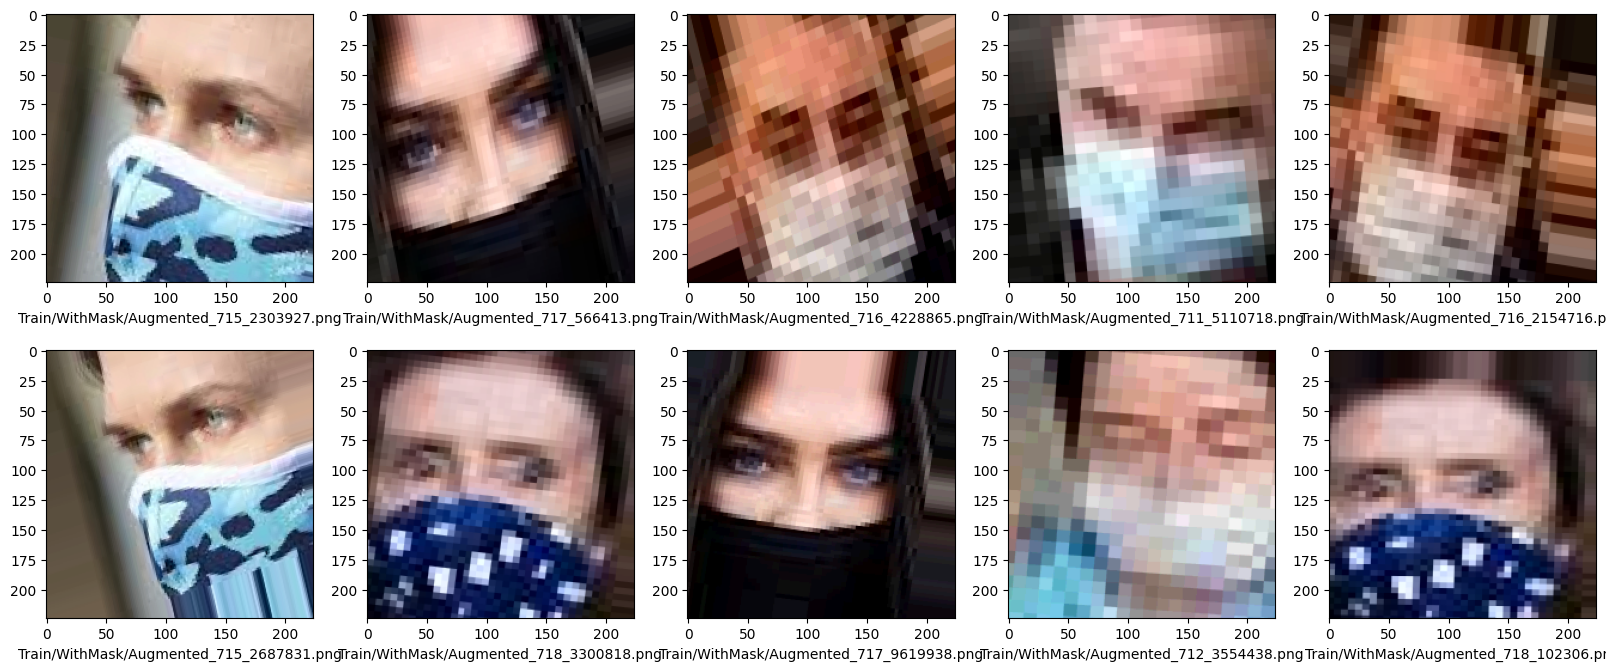

In [10]:
#view sample of mask images
plt.rcParams["figure.figsize"] = (20,8)
for idx, filename in enumerate(withmask_files[:10]):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(filename)

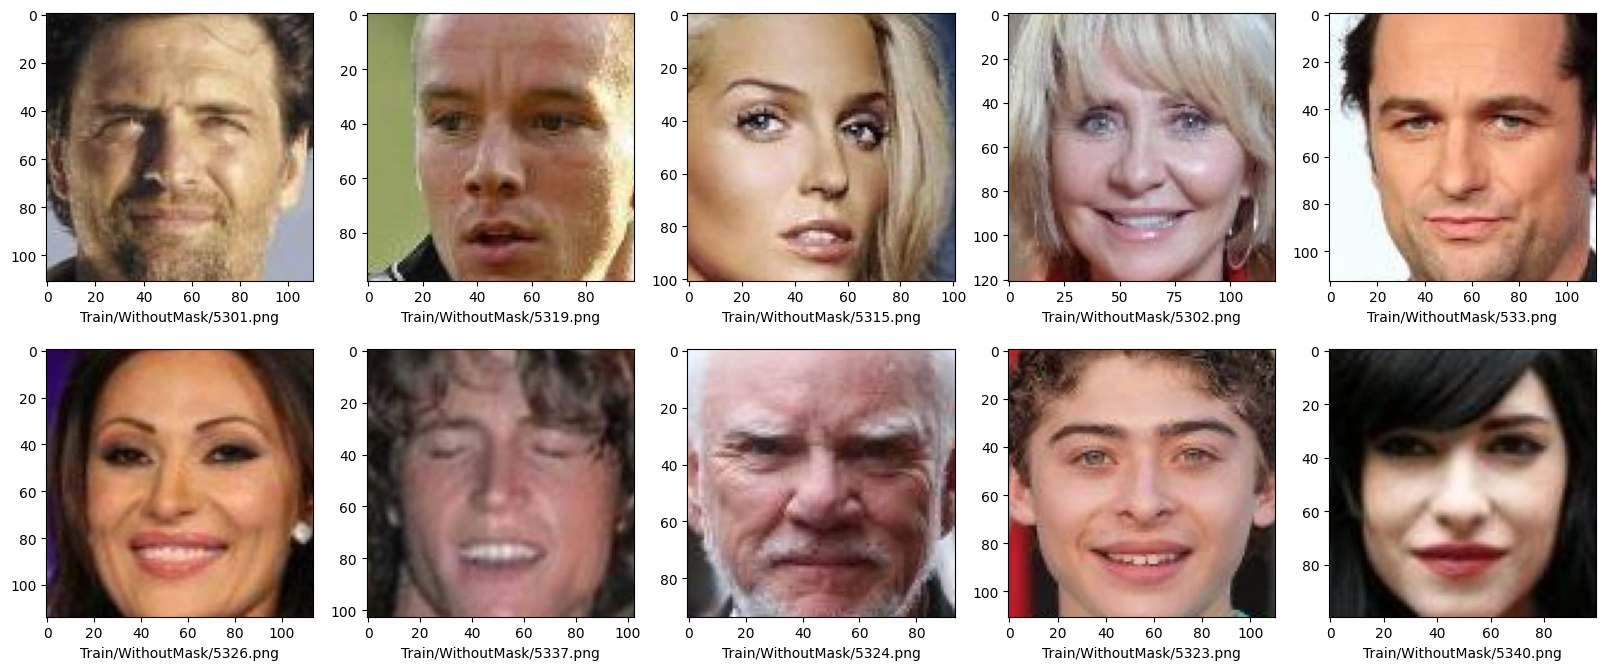

In [11]:
#view sample of without mask images
plt.rcParams["figure.figsize"] = (20,8)
for idx, filename in enumerate(withoutmask_files[:10]):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, idx+1)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(filename)

In [12]:
#initialize image generator for image augmentation for train ds
train_image_gen=ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=.2,
                    zoom_range=.2,
                    horizontal_flip=True)


#initialize image generator for image augmentation for test and val ds
test_image_gen=ImageDataGenerator(rescale=1./255)

val_image_gen = ImageDataGenerator(rescale=1./255)

In [13]:
#loading and preprocessing data 
BATCH_SIZE = 64
IMG_SIZE = (256, 256)


#assigning variables for the different classes in the dataset
train_generator = train_image_gen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='binary')

validation_generator = train_image_gen.flow_from_directory(
    directory=validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary')

test_generator = test_image_gen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary')

sample_gen = test_image_gen.flow_from_directory(
    directory=samples,
    target_size=IMG_SIZE,
    shuffle=False,
    class_mode=None)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 994 images belonging to 2 classes.
Found 6 images belonging to 1 classes.


In [14]:
# class names split into with and without mask
class_names = train_generator.class_indices
print(class_names)

{'WithMask': 0, 'WithoutMask': 1}


In [15]:
#image augmentation
images, tags = next(train_generator)
len(images)

64

In [16]:
images[0].shape

(256, 256, 3)

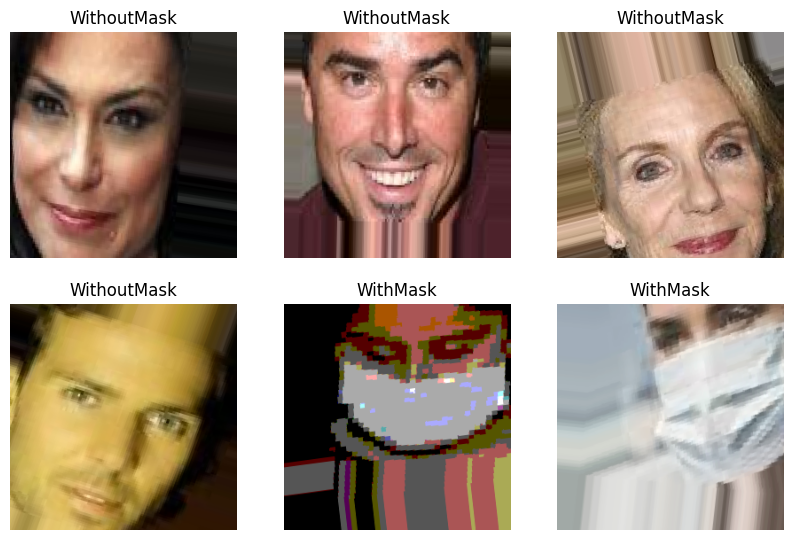

In [17]:
#visualise preprocessed/augmented images with their tags/classes
plt.figure(figsize=(10, 10))
for idx, image in enumerate(zip(images[:6], tags[:6])):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image[0])
    plt.title(list(class_names.keys())[int(image[1])])
    plt.axis("off")


# Build and compile the model

## Custom Model

In [18]:
#using the keras model to build the model
num_classes = 2

model1 = models.Sequential()
model1.add(layers.Conv2D(32, 3, activation='relu', input_shape=(256, 256,3)))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
model1.add(layers.MaxPooling2D(pool_size=(2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dropout(0.4))
model1.add(layers.Dense(num_classes, activation='softmax'))

model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 63, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0

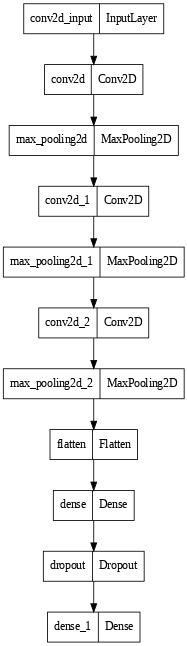

In [34]:
#visualise the custom model architecture
tf.keras.utils.plot_model(model1,dpi=60, to_file="model1.png")

In [20]:
#defining callback function to monitor accuracy and validation loss if model does not improve after 3 epochs
earlystopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1)

#Train model
history1 = model1.fit(train_generator, epochs=10,steps_per_epoch=20, validation_data=validation_generator, callbacks = [earlystopping])

Epoch 1/10
20/20 [==============================] - 52s 3s/step - loss: 1.3171 - accuracy: 0.6875 - val_loss: 0.3594 - val_accuracy: 0.8675
Epoch 2/10
20/20 [==============================] - 49s 2s/step - loss: 0.3127 - accuracy: 0.8844 - val_loss: 0.2696 - val_accuracy: 0.8913
Epoch 3/10
20/20 [==============================] - 48s 2s/step - loss: 0.2346 - accuracy: 0.9117 - val_loss: 0.2316 - val_accuracy: 0.9112
Epoch 4/10
20/20 [==============================] - 48s 2s/step - loss: 0.2007 - accuracy: 0.9234 - val_loss: 0.1914 - val_accuracy: 0.9275
Epoch 5/10
20/20 [==============================] - 48s 2s/step - loss: 0.2432 - accuracy: 0.9102 - val_loss: 0.2549 - val_accuracy: 0.9062
Epoch 6/10
20/20 [==============================] - 48s 2s/step - loss: 0.2197 - accuracy: 0.9148 - val_loss: 0.2651 - val_accuracy: 0.9038
Epoch 7/10
20/20 [==============================] - 48s 2s/step - loss: 0.2170 - accuracy: 0.9164 - val_loss: 0.1803 - val_accuracy: 0.9375
Epoch 8/10
20/20 [==

## VGG16

In [21]:
#loading the pre-trained model

from tensorflow.keras.applications.vgg16 import VGG16

vgg16_model = VGG16(input_shape = (256, 256, 3),include_top = False,weights = 'imagenet')

#freeze layers
for layer in vgg16_model.layers:
    layer.trainable = False

x = layers.Flatten()(vgg16_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 2 node for classification output
x = layers.Dense(2, activation='softmax')(x)

model2 = tf.keras.models.Model(inputs=vgg16_model.input, outputs=x)

model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

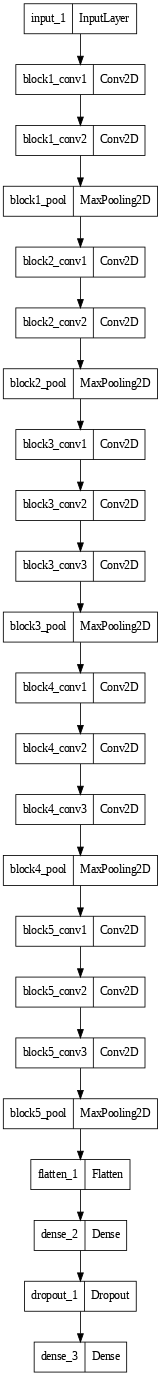

In [36]:
#visualise the model2 architecture
tf.keras.utils.plot_model(model2,dpi=60, to_file="model2.png")

In [23]:
#defining callback function to monitor accuracy and validation loss if model does not improve after 3 epochs
earlystopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1)

#Train model
history2 = model2.fit(train_generator, epochs=10,steps_per_epoch=100, validation_data=validation_generator, callbacks = [earlystopping])

Epoch 1/10
100/100 [==============================] - 337s 3s/step - loss: 0.5392 - accuracy: 0.9211 - val_loss: 0.0539 - val_accuracy: 0.9825
Epoch 2/10
100/100 [==============================] - 338s 3s/step - loss: 0.0978 - accuracy: 0.9661 - val_loss: 0.0530 - val_accuracy: 0.9837
Epoch 3/10
100/100 [==============================] - 338s 3s/step - loss: 0.0881 - accuracy: 0.9684 - val_loss: 0.0577 - val_accuracy: 0.9837
Epoch 4/10
100/100 [==============================] - 338s 3s/step - loss: 0.0979 - accuracy: 0.9627 - val_loss: 0.0534 - val_accuracy: 0.9837
Epoch 5/10
100/100 [==============================] - 336s 3s/step - loss: 0.0627 - accuracy: 0.9769 - val_loss: 0.0452 - val_accuracy: 0.9850
Epoch 6/10
100/100 [==============================] - 335s 3s/step - loss: 0.0650 - accuracy: 0.9789 - val_loss: 0.0396 - val_accuracy: 0.9887
Epoch 7/10
100/100 [==============================] - 339s 3s/step - loss: 0.0681 - accuracy: 0.9739 - val_loss: 0.0603 - val_accuracy: 0.9812

## DenseNet

In [24]:
from keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained weights
for layer in densenet_model.layers:
    layer.trainable = False

x = layers.Flatten()(densenet_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 2 node for classification output
x = layers.Dense(2, activation='softmax')(x)

model3 = tf.keras.models.Model(inputs=densenet_model.input, outputs=x)

# Compile the model with an optimizer, loss function, and metrics
model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

# Print a summary of the model architecture
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

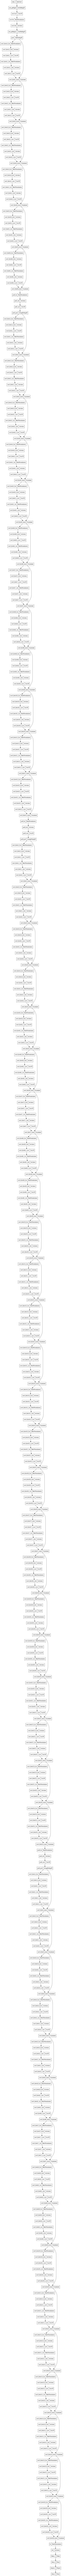

In [37]:
#visualise the model3 architecture
tf.keras.utils.plot_model(model3,dpi=60, to_file="model3.png")

In [26]:
#defining callback function to monitor accuracy and validation loss if model does not improve after 3 epochs
earlystopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1)

#Train model
history3 = model3.fit(train_generator, epochs=10,steps_per_epoch=100, validation_data=validation_generator, callbacks = [earlystopping])

Epoch 1/10
100/100 [==============================] - 235s 2s/step - loss: 2.4648 - accuracy: 0.9600 - val_loss: 0.2061 - val_accuracy: 0.9925
Epoch 2/10
100/100 [==============================] - 224s 2s/step - loss: 0.3799 - accuracy: 0.9871 - val_loss: 0.1478 - val_accuracy: 0.9950
Epoch 3/10
100/100 [==============================] - 221s 2s/step - loss: 0.1535 - accuracy: 0.9897 - val_loss: 0.1099 - val_accuracy: 0.9937
Epoch 4/10
100/100 [==============================] - 225s 2s/step - loss: 0.1344 - accuracy: 0.9909 - val_loss: 0.0417 - val_accuracy: 0.9962
Epoch 5/10
100/100 [==============================] - 225s 2s/step - loss: 0.1275 - accuracy: 0.9910 - val_loss: 0.0274 - val_accuracy: 0.9975
Epoch 6/10
100/100 [==============================] - 227s 2s/step - loss: 0.0776 - accuracy: 0.9926 - val_loss: 0.0371 - val_accuracy: 0.9975
Epoch 7/10
100/100 [==============================] - 224s 2s/step - loss: 0.0584 - accuracy: 0.9944 - val_loss: 0.0292 - val_accuracy: 0.9950

## InceptionV3

In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Load the pre-trained InceptionV3 model
iV3_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3))

# Freeze the pre-trained weights
for layer in iV3_model.layers:
    layer.trainable = False

x = layers.Flatten()(iV3_model.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 2 node for classification output
x = layers.Dense(2, activation='softmax')(x)

model4 = tf.keras.models.Model(inputs=iV3_model.input, outputs=x)

# Compile the model with an optimizer, loss function, and metrics
model4.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

# Print a summary of the model architecture
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 127, 127, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d_3[0][0]']               
 alization)                     )                                                           

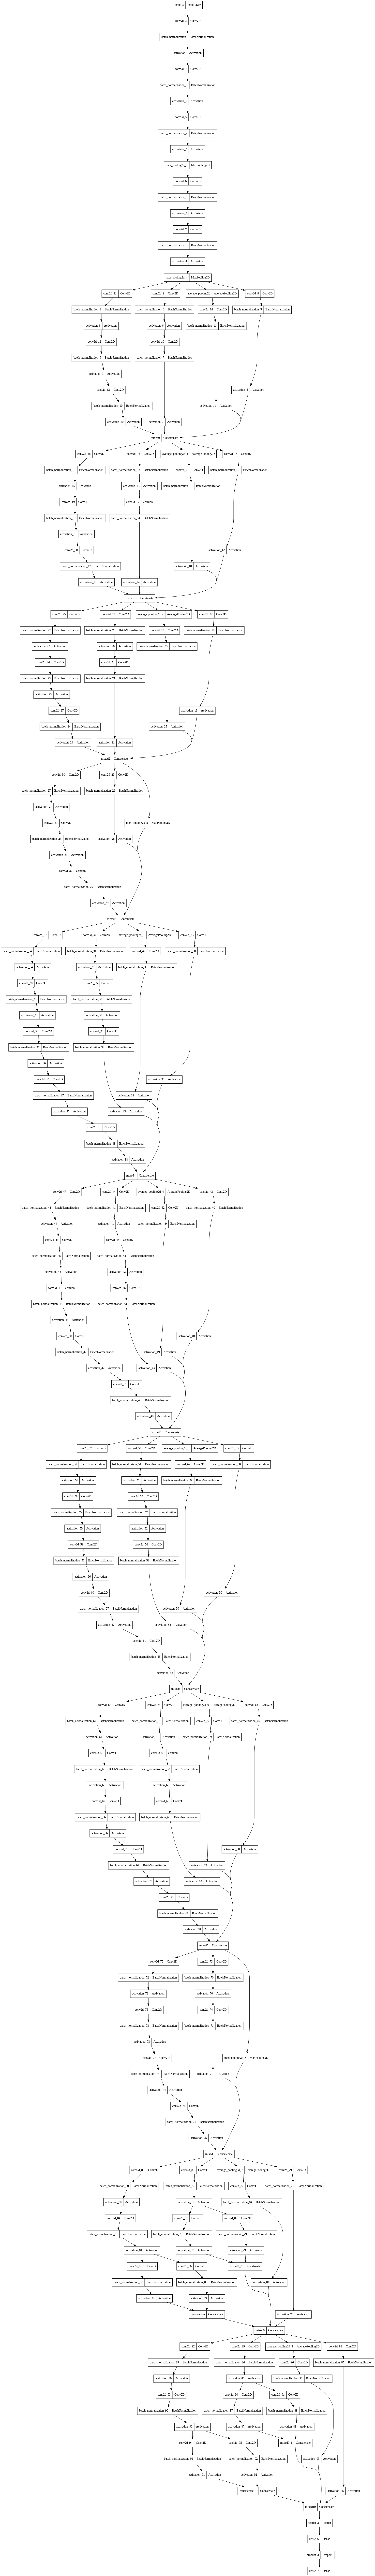

In [28]:
tf.keras.utils.plot_model(model4,dpi=96)

In [29]:
#defining callback function to monitor accuracy and validation loss if model does not improve after 3 epochs
earlystopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1)

#Train model
history4 = model4.fit(train_generator, epochs=10,steps_per_epoch=100, validation_data=validation_generator, callbacks = [earlystopping])

Epoch 1/10
100/100 [==============================] - 181s 2s/step - loss: 4.0798 - accuracy: 0.9511 - val_loss: 0.0953 - val_accuracy: 0.9950
Epoch 2/10
100/100 [==============================] - 173s 2s/step - loss: 0.3054 - accuracy: 0.9861 - val_loss: 0.0465 - val_accuracy: 0.9950
Epoch 3/10
100/100 [==============================] - 177s 2s/step - loss: 0.1283 - accuracy: 0.9868 - val_loss: 0.0635 - val_accuracy: 0.9925
Epoch 4/10
100/100 [==============================] - 176s 2s/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.0168 - val_accuracy: 0.9950
Epoch 4: early stopping


## MobileNetV2

In [30]:
#import pre-trained model for MobileNetV2
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 backbone and define the input shape
backbone = MobileNetV2(input_shape=(256, 256, 3),  include_top=False, weights='imagenet')

# Freeze the pre-trained weights
for layer in backbone.layers:
    layer.trainable = False

x = layers.Flatten()(backbone.output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final softmax layer with 2 node for classification output
x = layers.Dense(2, activation='softmax')(x)

model5 = tf.keras.models.Model(inputs=backbone.input, outputs=x)

# Compile the model with an optimizer, loss function, and metrics
model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

# Print a summary of the model architecture
model5.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                           

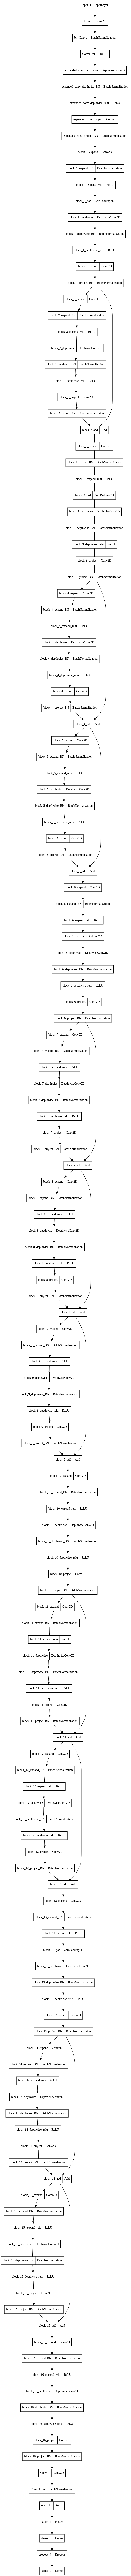

In [31]:
#visualise the model5 architecture
tf.keras.utils.plot_model(model5,dpi=96)

In [32]:
#defining callback function to monitor accuracy and validation loss if model does not improve after 3 epochs
earlystopping = EarlyStopping(monitor="val_accuracy", mode="max", patience=3, restore_best_weights=True, verbose=1)

#Train model
history5 = model5.fit(train_generator, epochs=10,steps_per_epoch=100, validation_data=validation_generator, callbacks = [earlystopping])

Epoch 1/10
100/100 [==============================] - 162s 2s/step - loss: 3.9886 - accuracy: 0.9260 - val_loss: 0.1124 - val_accuracy: 0.9862
Epoch 2/10
100/100 [==============================] - 159s 2s/step - loss: 0.1264 - accuracy: 0.9731 - val_loss: 0.0325 - val_accuracy: 0.9825
Epoch 3/10
100/100 [==============================] - 160s 2s/step - loss: 0.0501 - accuracy: 0.9841 - val_loss: 0.0303 - val_accuracy: 0.9900
Epoch 4/10
100/100 [==============================] - 160s 2s/step - loss: 0.0482 - accuracy: 0.9830 - val_loss: 0.0276 - val_accuracy: 0.9912
Epoch 5/10
100/100 [==============================] - 161s 2s/step - loss: 0.0556 - accuracy: 0.9828 - val_loss: 0.0235 - val_accuracy: 0.9937
Epoch 6/10
100/100 [==============================] - 159s 2s/step - loss: 0.0575 - accuracy: 0.9825 - val_loss: 0.0102 - val_accuracy: 0.9975
Epoch 7/10
100/100 [==============================] - 157s 2s/step - loss: 0.0588 - accuracy: 0.9828 - val_loss: 0.0250 - val_accuracy: 0.9937

# Model evaluation

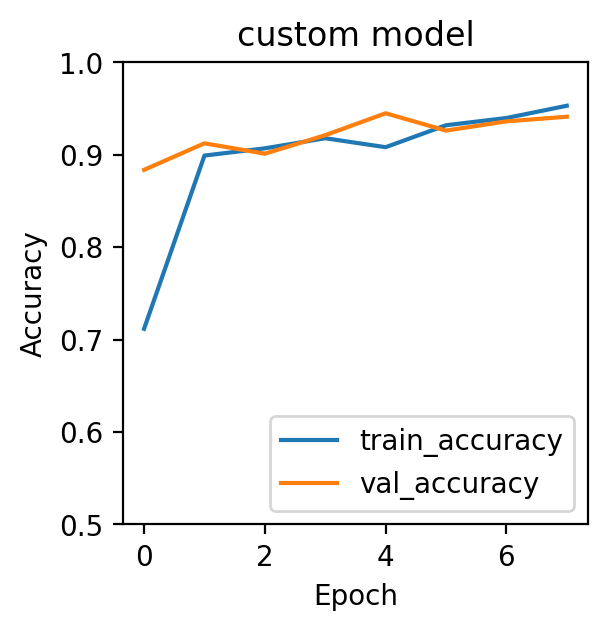

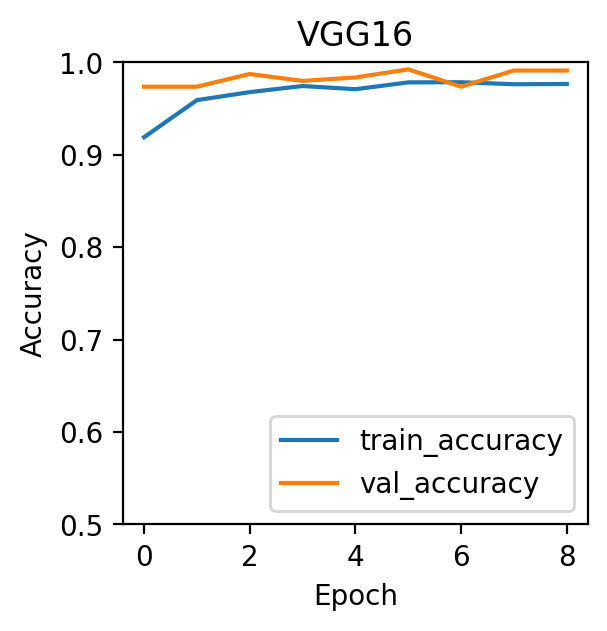

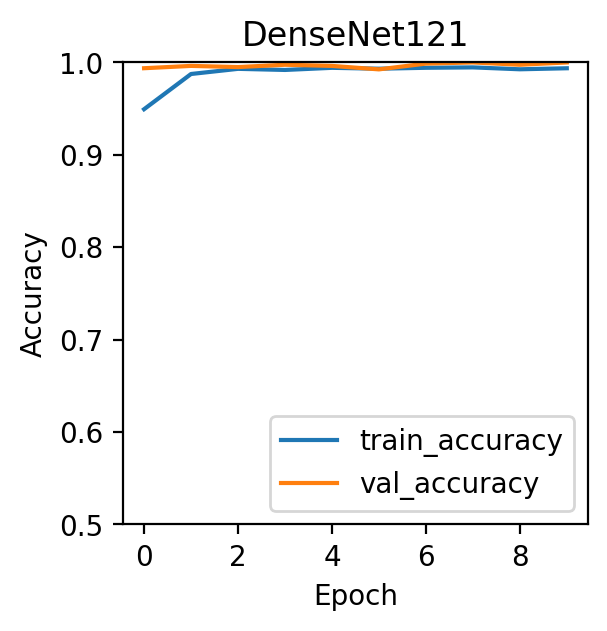

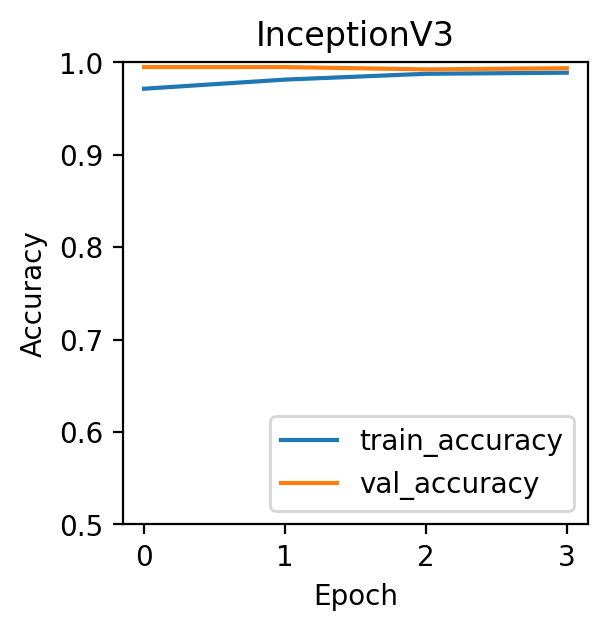

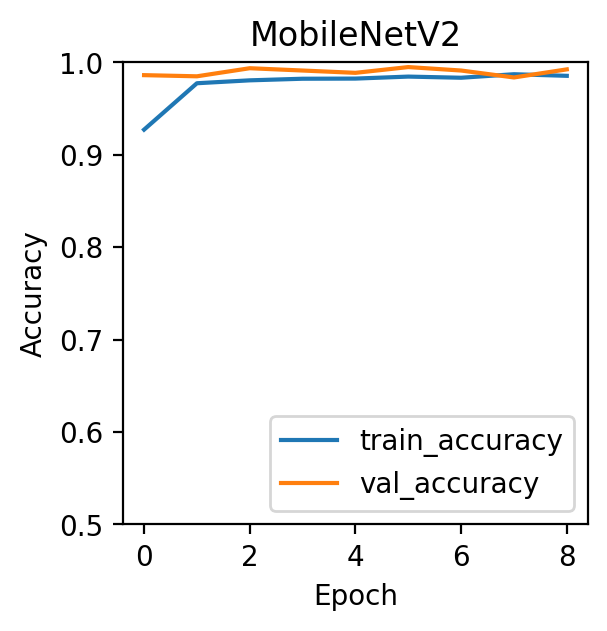

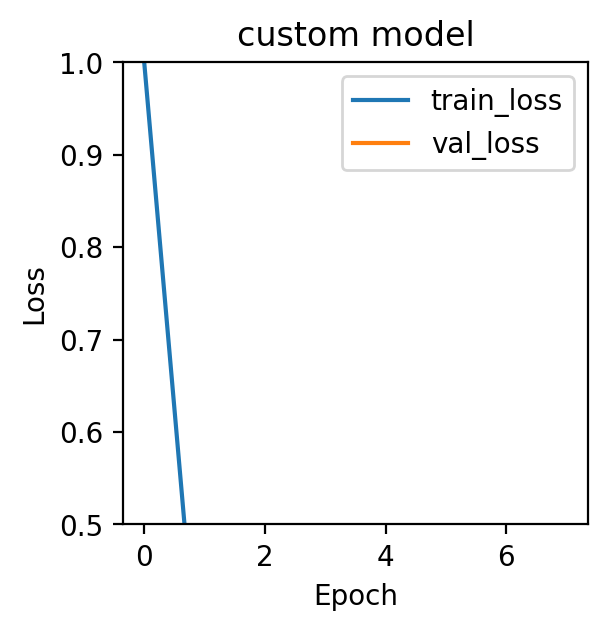

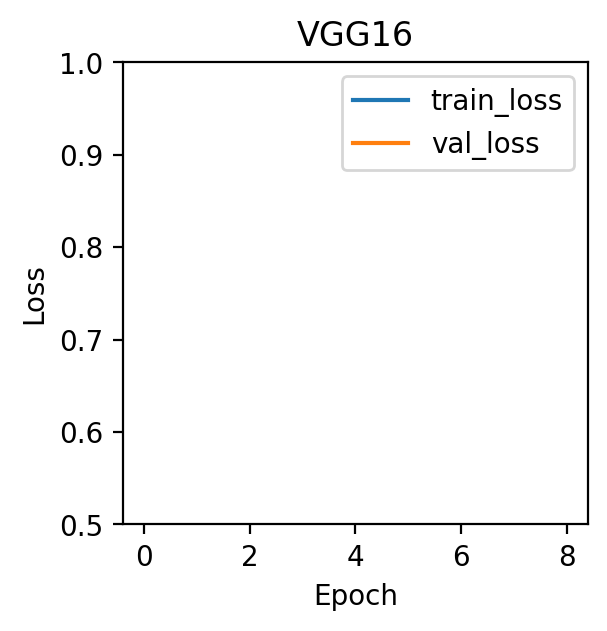

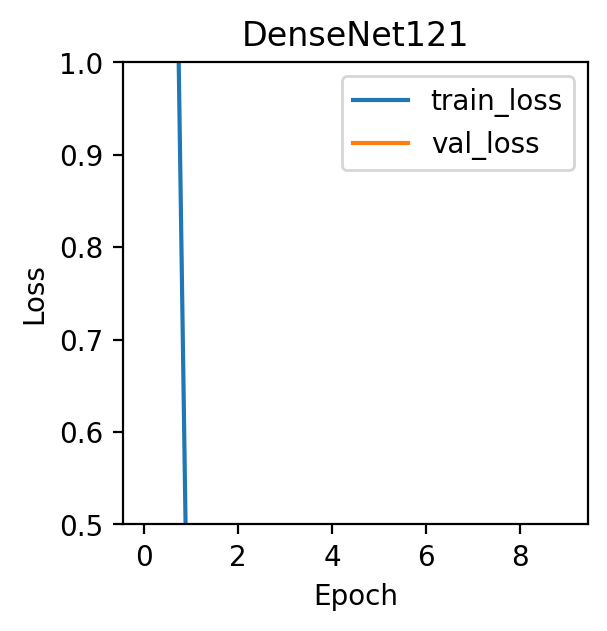

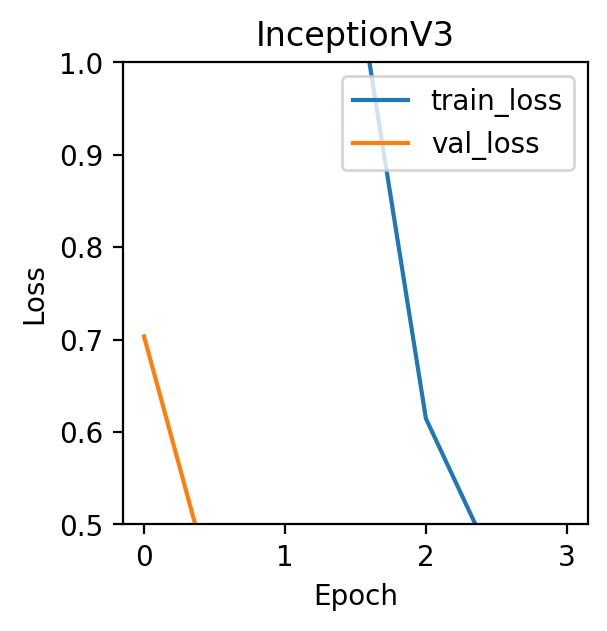

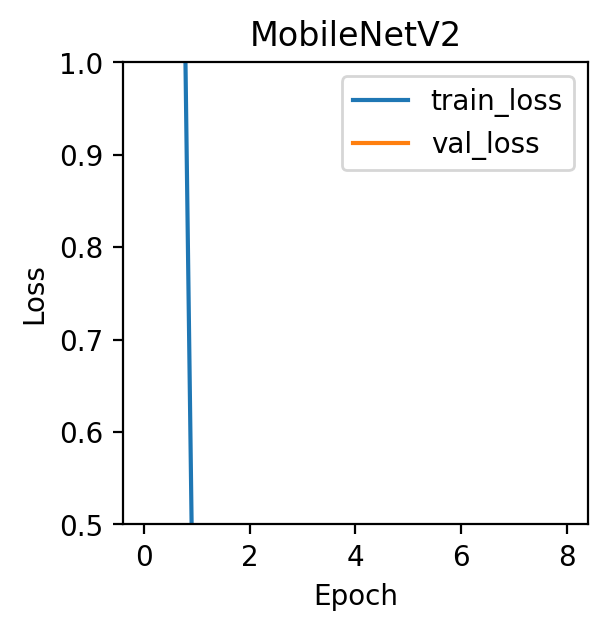

In [103]:
#visualization of the Accuracies and losses
models = {'custom model':[model1, history1],
          'VGG16':[model2, history2],
          'DenseNet121':[model3, history3],
          'InceptionV3':[model4, history4],
          'MobileNetV2':[model5, history5]}

plt.rcParams["figure.figsize"] = (20,8)
for i, model in enumerate(models.keys()):
  plt.figure(dpi=200, figsize = (3,3))
  plt.plot(models[model][1].history['accuracy'], label='train_accuracy')
  plt.plot(models[model][1].history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(model)
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')


plt.rcParams["figure.figsize"] = (20,8)
for i, model in enumerate(models.keys()):
  plt.figure(dpi=200, figsize = (3,3))
  plt.plot(models[model][1].history['loss'], label='train_loss')
  plt.plot(models[model][1].history['val_loss'], label = 'val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(model)
  plt.ylim([0.5, 1])
  plt.legend(loc='upper right')

In [134]:
#confusion matrix plot function 
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `noramlize=True`
    '''
    plt.rcParams["figure.figsize"] = (4,8)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without Normalized')
    
    print(cm)
    
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [135]:
def get_classification_report(model):
    preds = model.predict(test_generator, verbose=1)
    preds = np.argmax(preds, axis=1)
    print(classification_report(test_generator.classes, preds, target_names=['withFaceMask','withoutFaceMask']))
    cm =confusion_matrix(test_generator.classes, preds)
    plot_confusion_matrix(cm=cm, classes=['withFaceMask','withoutFaceMask'])

16/16 [==============================] - 5s 330ms/step
                 precision    recall  f1-score   support

   withFaceMask       0.98      0.91      0.94       484
withoutFaceMask       0.92      0.98      0.95       510

       accuracy                           0.95       994
      macro avg       0.95      0.95      0.95       994
   weighted avg       0.95      0.95      0.95       994

confusion matrix, without Normalized
[[441  43]
 [ 10 500]]


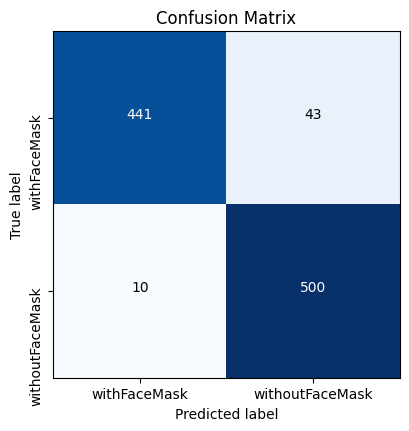

In [136]:
#Classification report
#custom model
get_classification_report(model1)

16/16 [==============================] - 44s 3s/step
                 precision    recall  f1-score   support

   withFaceMask       0.99      1.00      0.99       484
withoutFaceMask       1.00      0.99      0.99       510

       accuracy                           0.99       994
      macro avg       0.99      0.99      0.99       994
   weighted avg       0.99      0.99      0.99       994

confusion matrix, without Normalized
[[483   1]
 [  5 505]]


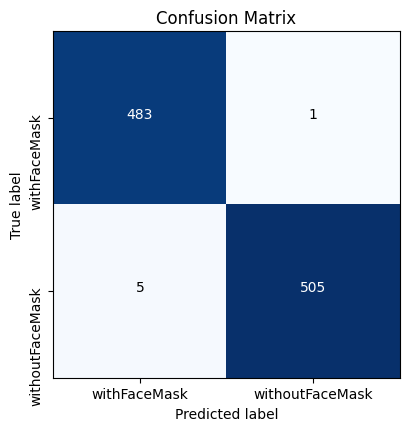

In [137]:
#VGG16
get_classification_report(model2)

16/16 [==============================] - 28s 2s/step
                 precision    recall  f1-score   support

   withFaceMask       0.99      1.00      1.00       484
withoutFaceMask       1.00      0.99      1.00       510

       accuracy                           1.00       994
      macro avg       1.00      1.00      1.00       994
   weighted avg       1.00      1.00      1.00       994

confusion matrix, without Normalized
[[484   0]
 [  3 507]]


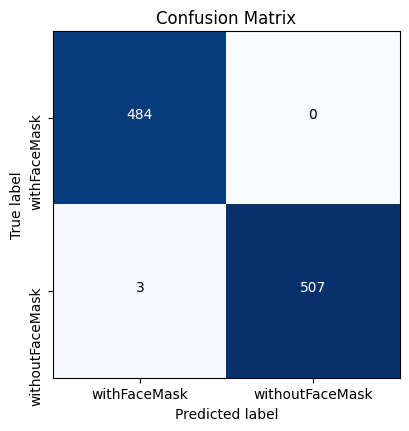

In [138]:
#DenseNet121
get_classification_report(model3)

16/16 [==============================] - 11s 670ms/step
                 precision    recall  f1-score   support

   withFaceMask       0.99      0.99      0.99       484
withoutFaceMask       0.99      0.99      0.99       510

       accuracy                           0.99       994
      macro avg       0.99      0.99      0.99       994
   weighted avg       0.99      0.99      0.99       994

confusion matrix, without Normalized
[[481   3]
 [  3 507]]


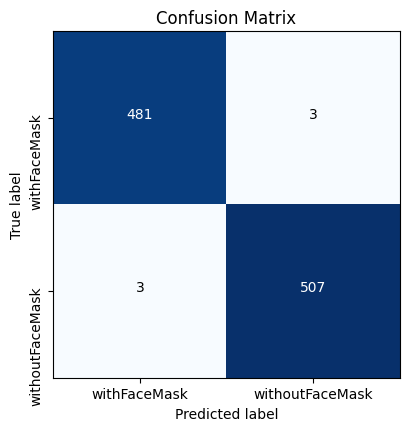

In [139]:
#InceptionV3
get_classification_report(model4)

16/16 [==============================] - 9s 562ms/step
                 precision    recall  f1-score   support

   withFaceMask       0.98      1.00      0.99       484
withoutFaceMask       1.00      0.98      0.99       510

       accuracy                           0.99       994
      macro avg       0.99      0.99      0.99       994
   weighted avg       0.99      0.99      0.99       994

confusion matrix, without Normalized
[[483   1]
 [ 10 500]]


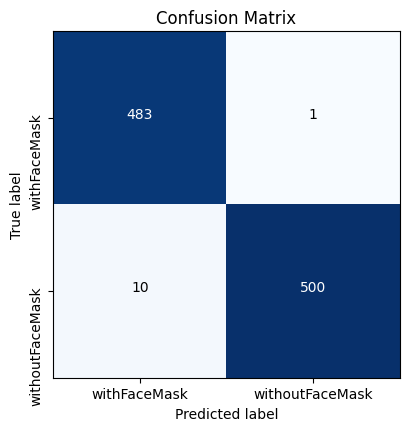

In [140]:
#MobileNetV2
get_classification_report(model5)

# model testing

In [67]:
#test model on sample images
predictions = model3.predict(sample_gen)
images = sample_gen.next()

(6, 256, 256, 3)

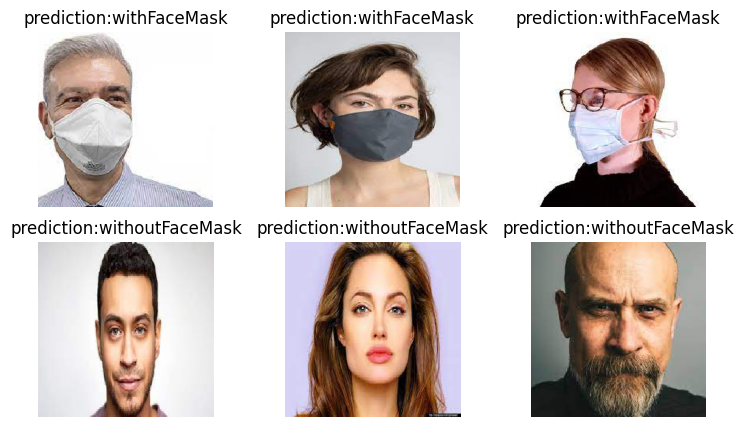

In [108]:
plt.figure(figsize=(9, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    pred = np.argmax(predictions[i])
    pred = ['withFaceMask','withoutFaceMask'][pred]
    plt.imshow(images[i])
    plt.title(f'prediction:{pred}')
    plt.axis("off")